In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

### Generate synthetic data

In [2]:
# from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

# N = 10000
# M = 30
# K = 2 # binary problem (class labels: {1,2})
# NUM_SPLITS = 3

# Ds = [] # data
# Xs = [] # features
# Ls = [] # noisy labels
# Ys = [] # true labels
# for _ in range(NUM_SPLITS):
#     L, Y, _ = generate_single_task_unipolar(
#         N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
#         class_balance=[0.3, 0.7], seed=1)
    
#     X, D = gaussian_bags_of_words(Y, vocab1k)
    
#     Ls.append(L)
#     Ys.append(Y)
#     Ds.append(D)
#     Xs.append(X)

### Load YouTube source data

In [3]:
import os
import pandas as pd

# DATA_FILEPATH = os.environ['METALHOME'] + '/data/source_clicks.csv'
DATA_FILEPATH = os.environ['METALHOME'] + '/data/snorkel_527610_100Kposneg.csv'

L_data = pd.read_csv(DATA_FILEPATH).sample(10000).reset_index(drop=True)

N = L_data.shape[0]
print(f"Number of items: {N}")
L_data[:20]

Number of items: 10000


,event_id,spam_label_ids,organic_label_ids
0,1528291117986164:181614023:990035844,NaN,0:6
1,1528007155560966:174093957:50873945,NaN,0
2,1528404965379990:176056194:3271892831,NaN,1
3,1527832766087949:169557517:2953696994,NaN,0
4,1528537737733629:181617606:1778831748,NaN,0
5,1527925188842250:181766341:2114970141,NaN,4:1
6,1528271240549429:169578966:117452686,17:14:15,NaN
7,1528366564782164:181617602:2030893217,16,0
8,1528293477902094:180402841:3926635366,17,NaN
9,1528566487786650:180404421:2986661743,3,NaN


In [6]:
from itertools import chain
from scipy.sparse import lil_matrix
import numpy as np

# YouTube
# DELIMITER = ','
# SPAM = 'spam_labels'
# HAM = 'ham_labels'

# GDN
DELIMITER = ':'
HAM = 'organic_label_ids'
SPAM = 'spam_label_ids'

# Get the pos/neg LF idxs, total number M
def split_LF_idxs(x):
    return map(int, x.split(DELIMITER)) if isinstance(x, str) else []

def get_LF_idxs(col):
    return set(chain.from_iterable([split_LF_idxs(x) for x in col]))

LF_pos_idxs = get_LF_idxs(L_data.iloc[:,1])
LF_neg_idxs = get_LF_idxs(L_data.iloc[:,2])
M = max(LF_pos_idxs | LF_neg_idxs) + 1

# Construct COO sparse matrix
L = lil_matrix((N, M))
for i, row in L_data.iterrows():
    for j in split_LF_idxs(row[SPAM]):
        L[i, j] = 1
    for j in split_LF_idxs(row[HAM]):
        L[i, j] = 2

# Convert to CSR matrix
L = L.tocsr().astype(np.int)
Ls = [L]

In [7]:
Ls[0]

<10000x98 sparse matrix of type '<class 'numpy.int64'>'
	with 23603 stored elements in Compressed Sparse Row format>

### Apply LabelModel

Reaffirming seed=2
Reaffirming n_epochs=1000
Reaffirming lr=0.001
Reaffirming print_at=100
Reaffirming show_plots=True
Reaffirming class_balance_init=[0.5, 0.5]
Overwriting l2=0.1 to l2=0.01
[Epoch 0] Loss: 542.847605
[Epoch 100] Loss: 0.326833
[Epoch 200] Loss: 0.137557
[Epoch 300] Loss: 0.120716
[Epoch 400] Loss: 0.116901
[Epoch 500] Loss: 0.115165
[Epoch 600] Loss: 0.114172
[Epoch 700] Loss: 0.113539
[Epoch 800] Loss: 0.113108
[Epoch 900] Loss: 0.112799
[Epoch 999] Loss: 0.112571
Finished Training


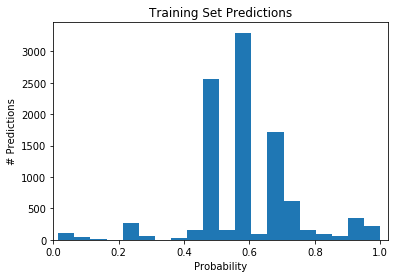

In [33]:
from metal.label_model import LabelModel

lm = LabelModel(seed=2)

y_pos = 0.5
lm.train(Ls[0], n_epochs=1000, lr=0.001, print_at=100, show_plots=True,
         class_balance_init=[y_pos, 1-y_pos], l2=0.01)

# Y_p = lm.score(Ls[1], Ys[1], metric='f1')

In [34]:
Y_p = lm.predict(Ls[0])

In [35]:
sorted(list(zip(
    lm._alphas().numpy(),
    lm._betas().numpy(),
    lm.polarity
)), key=lambda x : x[1])

[(0.95, 0.0072504940407994364, 1),
 (0.05, 0.007668903635806409, 0),
 (0.95, 0.008280781475647255, 1),
 (0.95, 0.008554496447132479, 1),
 (0.444084276145353, 0.01003202132578539, 1),
 (0.95, 0.01034292279712843, 1),
 (0.05, 0.011316782972793187, 1),
 (0.95, 0.01152529076056059, 1),
 (0.95, 0.011628561284663101, 1),
 (0.95, 0.011891225894239453, 1),
 (0.05, 0.011949494484841073, 1),
 (0.95, 0.012025023076111911, 0),
 (0.49628687738523797, 0.013744344723617203, 1),
 (0.05, 0.013769216880577811, 1),
 (0.05, 0.01455723918423503, 1),
 (0.05, 0.015143788234683424, 1),
 (0.95, 0.015609886540276454, 1),
 (0.29495256465655995, 0.01754769073308331, 1),
 (0.05, 0.01757609685486055, 1),
 (0.467780150629135, 0.01836746193231554, 1),
 (0.24145083095664485, 0.019066819127279123, 1),
 (0.95, 0.023849862304990543, 1),
 (0.9091365549615352, 0.024237868268711667, 1),
 (0.05, 0.02576236606218939, 1),
 (0.05, 0.026117217201592685, 1),
 (0.95, 0.029644287495365407, 1),
 (0.23994226760439366, 0.0300513175264

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lm._alphas().numpy())
plt.show()

In [ ]:
plt.hist(lm._betas().numpy())

### Random Search

In [ ]:
search_space = {
    'print_at': 200,
    'n_epochs': 1000, # a single constant value
    'l2': [0, 0.1, 0.01], # a list of discrete values
    'lr': {'range': [0.01, 0.0001], 'scale': 'log'}, # a range and scale to interpolate by
}

In [ ]:
from metal.tuner import ModelTuner

tuner = ModelTuner(LabelModel)
init_args = []
train_args = [Ls[0]]
model, best_config = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                  search_space, max_search=5, metric='accuracy')

### Metrics

Calculate metrics in one of two ways.

1. Use metric_score() and pass the metric name
3. The the specific metric's function (e.g., accuracy_score())

In [ ]:
from metal.metrics import metric_score, accuracy_score

metric_score(Ys[1], Y_p, 'accuracy')
accuracy_score(Ys[1], Y_p)

Built-in metrics include:

In [ ]:
metric_score(Ys[1], Y_p, 'accuracy')
metric_score(Ys[1], Y_p, 'coverage')
metric_score(Ys[1], Y_p, 'precision')
metric_score(Ys[1], Y_p, 'recall')
metric_score(Ys[1], Y_p, 'f1')
metric_score(Ys[1], Y_p, 'fbeta', beta=1.0)

### Confusion matrix

In [ ]:
from metal.analysis import confusion_matrix
confusion_matrix(Y_p, Ys[1])

In [ ]:
confusion_matrix(Y_p, Ys[1], normalize=True)

In [ ]:
mat = confusion_matrix(Y_p, Ys[1], pretty_print=True)

### Error analysis

In [ ]:
from metal.analysis import error_buckets

buckets = error_buckets(Y_p, Ys[1], Ds[1])
tp = buckets[1,1]
fp = buckets[1,2]

In [ ]:
fp[:1]

In [ ]:
tp[:3]

### Label matrix analysis

In [26]:
from metal.analysis import (
    item_coverage,
    item_overlap,
    item_conflict,
    LF_accuracies,
    LF_coverages,
    LF_overlaps,
    LF_conflicts,
)

In [ ]:
item_coverage(Ls[0])

In [ ]:
item_overlap(Ls[0])

In [ ]:
item_conflict(Ls[0])

In [ ]:
# LF_accuracies(Ls[0], Ys[0])

In [ ]:
# LF_coverages(Ls[0])

In [ ]:
LF_overlaps(Ls[0])

In [ ]:
# LF_conflicts(Ls[0])

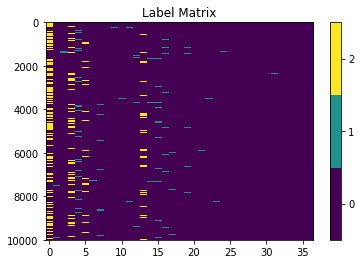

In [27]:
from metal.analysis import (
    view_label_matrix,
    view_overlaps,
    view_conflicts,
)

view_label_matrix(Ls[0])

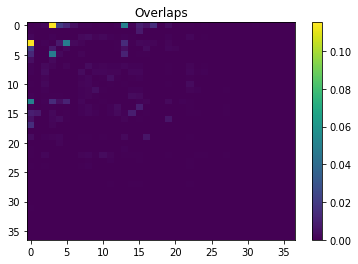

In [28]:
view_overlaps(Ls[0], normalize=True)

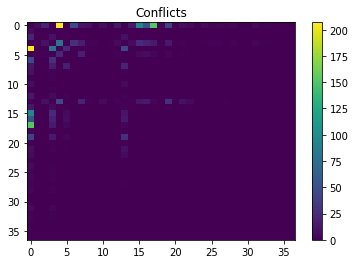

In [29]:
view_conflicts(Ls[0], normalize=False)